# Tutorial 3: performing physical optics propagations.

In this third tutorial, we take the same optical system as in tutorial 2. However, instead of performing ray-traces through the system, we perform physical optics (PO).

In [1]:
%matplotlib widget 
# Uncomment for interactive plots when running the notebook!
# Requires installation of the ipympl package

import numpy as np

from PyPO.System import System
from PyPO.Enums import FieldComponents, Projections, Units, Scales


In [2]:

s = System()

2026-03-01 15:40:50 - WARNING - System override set to True. 


2026-03-01 15:40:51 - INFO - Added plane plane_focus to system. 


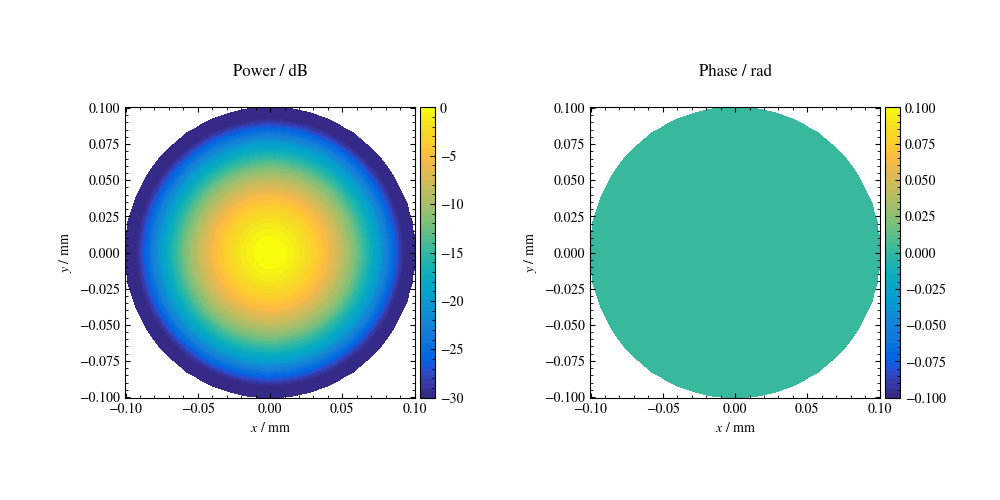

2026-03-01 15:40:52 - INFO - Translated element plane_focus by ('0.000e+00', '0.000e+00', '1.000e+02') millimeters. 


In [3]:
plane_focus = {
            "name"      : "plane_focus",
            "gmode"     : "uv",
            "lims_u"    : np.array([0, 0.1])*Units.MM,
            "lims_v"    : np.array([0, 360])*Units.DEG,
            "gridsize"  : np.array([101, 100])
            }

s.addPlane(plane_focus)

GPODict = {                                                                                                                                                                     
    "name"      : "focus",                                                                                                                                  
    "lam"       : 0.01*Units.MM,                                                                                                      
    "w0x"       : 0.05*Units.MM,                                                                                             
    "w0y"       : 0.05*Units.MM,                                                                                             
    "n"         : 1,                                                                                                                             
    "E0"        : 1,                                                                                                                                  
    "dxyz"      : 0,                                                                                                 
    "pol"       : np.array([1, 0, 0])                                                                                                          
}

s.createGaussian(GPODict, "plane_focus")
s.plotBeam2D("focus", FieldComponents.Ex, vmin=-30, vmax=0)

s.translateGrids("plane_focus", np.array([0, 0, 100])*Units.MM)


In [4]:
ellipse = {
            "name"      : "ellipsoid",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "flip"      : True,
            "focus_1"   : np.array([0, 0, 100])*Units.MM,
            "focus_2"   : np.array([0, 0, -100])*Units.MM,
            "orient"    : "z",
            "ecc"       : 0.5,
            "lims_u"    : np.array([0, 10])*Units.MM,
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([11, 10])
            }

s.addEllipse(ellipse)

plane_t = {
            "name"      : "plane_t",
            "gmode"     : "uv",
            "lims_u"    : np.array([0, 5])*Units.MM,
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([301, 300])
            }

s.addPlane(plane_t)
s.rotateGrids("plane_t", np.array([45, 0, 0]))

s.convergeOnTarget('focus', 'ellipsoid', 'plane_t', tol=1e-3)


2026-03-01 15:40:53 - INFO - Added ellipsoid ellipsoid to system. 
2026-03-01 15:40:53 - INFO - Added plane plane_t to system. 
2026-03-01 15:40:53 - INFO - Rotated element plane_t by ('4.500e+01', '0.000e+00', '0.000e+00') degrees around ('0.000e+00', '0.000e+00', '0.000e+00'). 
2026-03-01 15:40:53 - WORK - *** Starting auto-convergence of ellipsoid on plane_t ***  
2026-03-01 15:40:54 - WORK - Difference : 2.397542532365517 at gridsize[20] 
2026-03-01 15:40:54 - WORK - Difference : 0.9582182629343492 at gridsize[40] 
2026-03-01 15:40:55 - WORK - Difference : 0.19021294846969655 at gridsize[80] 
2026-03-01 15:40:55 - WORK - Difference : 0.013019162059515253 at gridsize[160] 
2026-03-01 15:40:57 - WORK - Difference : 0.006786044527083527 at gridsize[320] 
2026-03-01 15:40:57 - WORK - Difference : 0.007815280236785915 at gridsize[640] 
2026-03-01 15:40:57 - WORK - Difference : 0.003848008200812687 at gridsize[1280] 
2026-03-01 15:40:58 - WORK - Difference : 0.001562316457383145 at grids

array([5120,  240])

In [5]:
s.system['ellipsoid']['gridsize']

array([5120,  240])

Next we must run the PO from the focus to the ellipsoid, to generate the source that will used to
converge the plane_t grid on the paraboloid.

In [6]:
device = 'GPU'

focus_to_ell_PO = {
    "t_name"      : "ellipsoid",
    "s_current"   : "focus",
    "mode"        : "JM",
    "name_JM"     : "JM_ell",
    "device"      : device
}

s.runPO(focus_to_ell_PO)

2026-03-01 15:41:06 - WORK - *** Starting PO propagation *** 
2026-03-01 15:41:06 - WORK - Propagating focus on plane_focus to ellipsoid, propagation mode: JM. 
2026-03-01 15:41:06 - WORK - Hardware: running 256 CUDA threads per block. 
2026-03-01 15:41:06 - WORK - ... Calculating ... 
2026-03-01 15:41:08 - WORK - *** Finished: 1.691 seconds *** 


Now we can add the parabola, and run the convergence on the plane_t.

The source for this convergence is the currents on the ellipsoid, `JM_ell`.

In [7]:
parabola = {
            "name"      : "paraboloid",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "focus_1"   : np.array([0, -100, 0])*Units.MM,
            "vertex"    : np.array([-10, -100, 0])*Units.MM,
            "lims_u"    : np.array([0, .5])*Units.MM,
            "lims_v"    : np.array([0, 360]),
            "gcenter"   : np.array([0,-20])*Units.MM,
            "gridsize"  : np.array([11, 10])
            }

s.addParabola(parabola)

s.convergeOnTarget('JM_ell', 'plane_t', 'paraboloid', tol=1e-3)


2026-03-01 15:41:09 - INFO - Added paraboloid paraboloid to system. 
2026-03-01 15:41:09 - WORK - *** Starting auto-convergence of plane_t on paraboloid ***  
2026-03-01 15:41:12 - WORK - Difference : 0.06814714885327348 at gridsize[20] 
2026-03-01 15:41:14 - WORK - Difference : 0.008725803166789038 at gridsize[40] 
2026-03-01 15:41:16 - WORK - Difference : 0.003298100074265321 at gridsize[80] 
2026-03-01 15:41:18 - WORK - Difference : 0.0014392319571009224 at gridsize[160] 
2026-03-01 15:41:20 - WORK - Difference : 0.0004905055062277366 at gridsize[320] 
2026-03-01 15:41:22 - WORK - Difference : 0.0010888478937615674 at gridsize[120] 
2026-03-01 15:41:23 - WORK - Difference : 0.0005716255410587134 at gridsize[140] 
2026-03-01 15:41:25 - WORK - Difference : 0.0006127605851868118 at gridsize[130] 
2026-03-01 15:41:27 - WORK - Difference : 0.06464890804622911 at gridsize[120] 
2026-03-01 15:41:31 - WORK - Difference : 0.06528442757251471 at gridsize[140] 
2026-03-01 15:41:33 - WORK - Dif

array([130, 160])

Now we run the PO from `ellipsoid` to the `plane_t`, to generate the currents on the `plane_t`, which will be the source for testing convergence of `paraboloid`'s grid on `plane_out`.

In [8]:
ell_to_plane_t_PO = {
    "t_name"      : "plane_t",
    "s_current"   : "JM_ell",
    "mode"        : "JM",
    "name_JM"     : "JM_pt",
    "device"      : device
}

s.runPO(ell_to_plane_t_PO)

2026-03-01 15:42:01 - WORK - *** Starting PO propagation *** 
2026-03-01 15:42:01 - WORK - Propagating JM_ell on ellipsoid to plane_t, propagation mode: JM. 
2026-03-01 15:42:01 - WORK - Hardware: running 256 CUDA threads per block. 
2026-03-01 15:42:01 - WORK - ... Calculating ... 
2026-03-01 15:42:10 - WORK - *** Finished: 8.862 seconds *** 


Now we create `plane_out`, and test the convergence of `paraboloid`'s grid on `plane_out`.

In [9]:
plane_out = {
            "name"      : "plane_out",
            "gmode"     : "xy",
            "lims_x"    : np.array([-2, 2])*Units.MM,
            "lims_y"    : np.array([-2, 2])*Units.MM,
            "gridsize"  : np.array([101, 101])
            }

s.addPlane(plane_out)
s.rotateGrids("plane_out", np.array([0, -90, 0]))
s.translateGrids("plane_out", np.array([50, -120, 0])*Units.MM)

2026-03-01 15:42:12 - INFO - Added plane plane_out to system. 
2026-03-01 15:42:12 - INFO - Rotated element plane_out by ('0.000e+00', '-9.000e+01', '0.000e+00') degrees around ('0.000e+00', '0.000e+00', '0.000e+00'). 
2026-03-01 15:42:12 - INFO - Translated element plane_out by ('5.000e+01', '-1.200e+02', '0.000e+00') millimeters. 


In [10]:
s.convergeOnTarget('JM_pt', 'paraboloid', 'plane_out', tol=1e-3)

2026-03-01 15:42:13 - WORK - *** Starting auto-convergence of paraboloid on plane_out ***  
2026-03-01 15:42:13 - WORK - Difference : 0.026809986091679103 at gridsize[20] 
2026-03-01 15:42:14 - WORK - Difference : 0.013007255541928484 at gridsize[40] 
2026-03-01 15:42:14 - WORK - Difference : 0.006492682968154442 at gridsize[80] 
2026-03-01 15:42:14 - WORK - Difference : 0.0031062495928203438 at gridsize[160] 
2026-03-01 15:42:14 - WORK - Difference : 0.001608333641015002 at gridsize[320] 
2026-03-01 15:42:14 - WORK - Difference : 0.0007648433565168972 at gridsize[640] 
2026-03-01 15:42:15 - WORK - Difference : 0.0006328502682764407 at gridsize[240] 
2026-03-01 15:42:15 - WORK - Difference : 0.00042360030439599495 at gridsize[200] 
2026-03-01 15:42:15 - WORK - Difference : 0.0002861468238082182 at gridsize[180] 
2026-03-01 15:42:15 - WORK - Difference : 0.19456462208297282 at gridsize[240] 
2026-03-01 15:42:15 - WORK - Difference : 0.19456012237439949 at gridsize[280] 
2026-03-01 15:42

array([180, 320])

Now we carry out the PO from `plane_t` to the paraboloid, and hence to `plane_out`.

In [11]:
plane_t_to_par_PO = {
    "t_name"      : "paraboloid",
    "s_current"   : "JM_pt",
    "mode"        : "JMEH",
    "name_JM"     : "JM_par",
    "name_EH"     : "EH_par",
    "device"      : device
}

s.runPO(plane_t_to_par_PO)

2026-03-01 15:42:17 - WORK - *** Starting PO propagation *** 
2026-03-01 15:42:17 - WORK - Propagating JM_pt on plane_t to paraboloid, propagation mode: JMEH. 
2026-03-01 15:42:17 - WORK - Hardware: running 256 CUDA threads per block. 
2026-03-01 15:42:17 - WORK - ... Calculating ... 
2026-03-01 15:42:18 - WORK - *** Finished: 0.341 seconds *** 


In [12]:
par_to_plane_out_PO = {
    "t_name"      : "plane_out",
    "s_current"   : "JM_par",
    "mode"        : "JMEH",
    "name_JM"     : "JM_out",
    "name_EH"     : "EH_out",
    "device"      : device
}

s.runPO(par_to_plane_out_PO)

2026-03-01 15:42:18 - WORK - *** Starting PO propagation *** 
2026-03-01 15:42:18 - WORK - Propagating JM_par on paraboloid to plane_out, propagation mode: JMEH. 
2026-03-01 15:42:18 - WORK - Hardware: running 256 CUDA threads per block. 
2026-03-01 15:42:18 - WORK - ... Calculating ... 
2026-03-01 15:42:19 - WORK - *** Finished: 0.258 seconds *** 


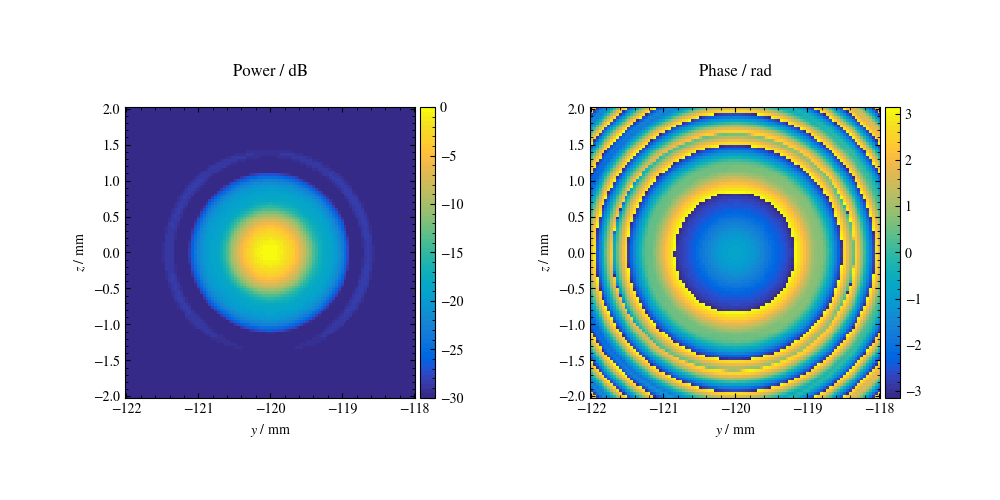

In [13]:
s.plotBeam2D("EH_out", FieldComponents.Ey, project=Projections.yz, vmin=-30, vmax=0)

We propagate the beam in the focus through the entire system onto the paraboloid reflector. We do not specify the "device" field in the PO dictionaries. This field defaults to "CPU" if the CUDA libraries are not compiled. If they are, the field defaults to "GPU". Similarly, the number of threads "nThreads" is not specified. If "device" = "CPU", "nThreads" defaults to the total number of CPU threads in your computer. If "device" = "GPU", "nThreads" defaults to 256 threads per CUDA block. In practice, this number is not critical and therefore does not have to be set often, but if set it should be a multiple of 32 (see [this link](https://en.wikipedia.org/wiki/Thread_block_(CUDA_programming)) for a good overview about CUDA blocks and threads).

We set, for the first two propagations, the "mode" parameter to "JM". This means we only store the calculated electric (J) and magnetic (M) currents on the target surface. If we specify "EH", such as for the last propagation, we only save the illuminating electric (E) and magnetic (H) field on the target surface. If we want both, we specify "mode" as "JMEH". Another option, "FF" for far-field, will be explained in more detail below. The last option, "EHP", stores the reflected field and corresponding Poynting vectors. With this option it is possible to do a combined ray-trace and PO approach. This will be introduced in a later tutorial.

In [14]:
plane_ff = {
            "name"      : "plane_ff",
            "gmode"     : "AoE",
            "lims_Az"    : np.array([-0.7, 0.7]) * 6,
            "lims_El"    : np.array([-0.7, 0.7]) * 6 + 90,
            "gridsize"  : np.array([301, 301])
            }
s.addPlane(plane_ff)

par_to_plane_ff_PO = {
    "t_name"      : "plane_ff",
    "s_current"   : "JM_par",
    "mode"        : "FF",
    "name_EH"     : "EH_FF",
    "device"      : device
}

s.runPO(par_to_plane_ff_PO)

2026-03-01 15:42:21 - INFO - Added plane plane_ff to system. 
2026-03-01 15:42:21 - WORK - *** Starting PO propagation *** 
2026-03-01 15:42:21 - WORK - Propagating JM_par on paraboloid to plane_ff, propagation mode: FF. 
2026-03-01 15:42:21 - WORK - Hardware: running 256 CUDA threads per block. 
2026-03-01 15:42:21 - WORK - ... Calculating ... 
2026-03-01 15:42:22 - WORK - *** Finished: 0.693 seconds *** 


Units.MM
mm


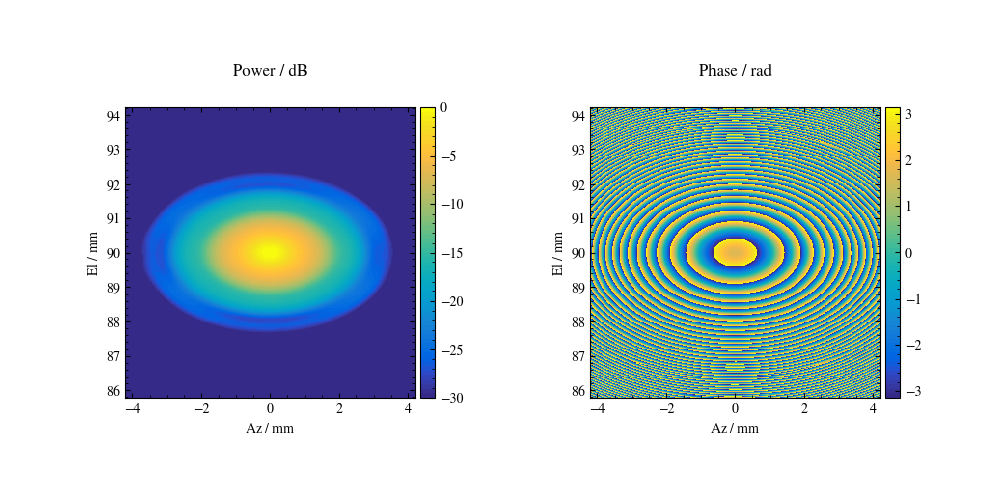

In [15]:
s.plotBeam2D("EH_FF", FieldComponents.Ey, vmin=-30, scale=Scales.dB)

In this final section, we propagated the field from the paraboloid to the far-field. We did this by specifying the "gmode" parameter to "AoE", which stands for Azimuth-over-Elevation (the only far-field co-ordinate system currently present in `PyPO`). The limits in "AoE" mode were given in degrees. Note that we subtracted 90 degrees from the Elevation limits. This is because the paraboloid illuminates the far-field along the x-axis. Also, note that the xyz components of the resulting far-field object do not align with the axes shown in the system plot. This is because, in the resulting fields object, x now aligns with the field along the Azimuthal direction (the y-axis in the original co-ordinate system) and y points along the Elevation direction (the z-axis in the original co-ordinate system). 